In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import baltic as bt
from scipy import stats, optimize
from math import ceil
from random import random

In [2]:
######  CONFIG  #####

# Pull pre-computed clade frequencies
dataset_name = 'SEAsia'
out_path = '../../../data/titer-model/frequencies/'
frequency_path = '../../../data/titer-model/frequencies/southeast_asia_clade_frequencies.csv'

# these are identical trees, but with `dTiter` values assigned by the titer model either to 
# all/any branch in the tree, or restricted to branches between serotypes
all_branch_effects_tree = '../../../data/titer-model/all-branch-effects/jsons/dengue_all_tree.json' 
interserotype_branch_effects_tree = '../../../data/titer-model/interserotype-branch-effects/jsons/dengue_all_tree.json'

# the node IDs ("clade" trait from augur) of the MRCAs of 
# all antigenically uniform clades (as determined by cTiter values in the all branch effects tree)
uniform_cTiter_clades = [4, 33, 117, 495, 975, 980, 996, 1017, 1020, 1033, 1089, 
                         1386, 1395, 1454, 1588, 1594, 1860, 2027, 2037, 2119, 
                         2167, 2173, 2185, 2230, 2238, 2588]

serotype_clades = [1859,1,1385,974] # serotype MRCAs
genotype_clades = [2185,2589,2238,2596,1460,1393,1587,1455,975,979,1089,33,497,117,543,4,638] # canonical genotype MRCAs

date_range = (1970., 2015.) # informative date range
years_back = 3 # how many years before the season of interest to look at past circulation
years_forward = 5 # how many years in the future to predict

In [3]:
# read in clade frequencies, format column headers and restrict to informative date range
frequencies = pd.read_csv(frequency_path, index_col=0)
frequencies.rename(columns={i:int(i) for i in frequencies.columns.values}, inplace=True)
frequencies = frequencies.loc[(frequencies.index >= date_range[0]) & (frequencies.index <= date_range[1])]

pivots = frequencies.index.tolist() # timepoints
n_years = int(pivots[-1]) - int(pivots[0]) # numer of years in the frequencies dataset
ppy = len(pivots)/n_years # pivots per year

pivots_back = years_back*ppy # number of timepoints to sum over
pivots_forward = years_forward*ppy # number of timepoints forward to look at

# timepoints with enough data before to estimate population exposure 
# and enough data afterwards to be able to check predictions
informative_pivots = pivots[pivots_back:-1*pivots_forward] 
informative_date_range = (informative_pivots[0], informative_pivots[-1])

In [4]:
#####   INPUT   #####
def get_frequency_ratio(pivots, pivots_forward, informative_date_range, frequencies):
    '''
    Returns pd.DataFrame(index=informative_pivots (t), columns=clades (i), values = frequency of clade i, x(i, t+n) / x(i))
    '''
    valid_start = pivots[:-1*pivots_forward] # enough data going forward
    valid_end = pivots[pivots_forward:] 
    delta_t = zip(valid_start, valid_end) 
    
    def ratio(start, end):
        if start < 0.1:
            return np.nan
        else:
            return end / start
    
    f_ratio = { i: [ratio(frequencies[i][start], frequencies[i][end]) for (start, end) in delta_t] for i in frequencies.columns.values}
    f_ratio = pd.DataFrame(f_ratio, index=valid_start)
    return f_ratio.loc[(f_ratio.index >= informative_date_range[0]) & (f_ratio.index <= informative_date_range[-1])]

actual_frequency_ratio = get_frequency_ratio(pivots, pivots_forward, informative_date_range, frequencies)

In [5]:
## Load both trees from JSON
all_branch_effects_tree = bt.loadJSON(all_branch_effects_tree, json_translation={'name': 'strain', 'height': 'xvalue'})
interserotype_branch_effects_tree = bt.loadJSON(interserotype_branch_effects_tree, json_translation = {'name': 'strain', 'height': 'xvalue'})

## { clade_ID_number: bt.node object }
all_branch_effects_clade_lookup = {int(k.traits['clade']) : k for k in all_branch_effects_tree.Objects}
interserotype_branch_effects_clade_lookup = {int(k.traits['clade']):k for k in interserotype_branch_effects_tree.Objects}

## check the trees are identical and copy the interserotype_dTiter values 
## so we can access both models' estimates in the same structure
for clade, k in all_branch_effects_clade_lookup.items():
    compare = interserotype_branch_effects_clade_lookup[clade]
    assert k.traits['strain'] == compare.traits['strain']
    
    k.traits['interserotype_dTiter'] = compare.traits['dTiter']
    
clade_lookup = all_branch_effects_clade_lookup
titer_tree = all_branch_effects_tree


Tree height: 0.368260
Tree length: 6.105600
annotations present

Numbers of objects in tree: 2996 (1426 nodes and 1570 leaves)


Tree height: 0.368260
Tree length: 6.105600
annotations present

Numbers of objects in tree: 2996 (1426 nodes and 1570 leaves)



In [6]:
all_branch_effects_dTiters = {} # store precomputed titers as we go
interserotype_effects_dTiters = {}

def get_dTiter(clade1, clade2, antigenic_resolution, clade_lookup=clade_lookup):
    key = tuple(sorted([clade1, clade2])) # sorted to avoid key errors

    if antigenic_resolution == 'serotype':
        dTiters = interserotype_effects_dTiters # pull the value from the interserotype model
        titer_trait = 'interserotype_dTiter'
    else:
        dTiters = all_branch_effects_dTiters
        titer_trait='dTiter'
        
    if key in dTiters: # precomputed for this model?
        return dTiters[key]

    elif clade1 == clade2: # identical? dTiter = 0. for either model
        dTiter = 0.

    else:
        k1, k2 = clade_lookup[clade1], clade_lookup[clade2]
        k1_trace = []
        k2_trace = []
        k = k1 ## Trace from the node 1 to the root (in order)
        while k.index != 'Root':
            k1_trace.append(k)
            k = k.parent
        k = k2 ## Start tracing from node2 to the root; break when we find the first node that's shared along node1's path
        while k not in k1_trace:
            k2_trace.append(k)
            k = k.parent
        else:
            mrca = k
        shared_k1_trace = k1_trace[:k1_trace.index(mrca)]
        k2_trace.reverse() # walk back down from the mrca, so the path is unidirectional
        total_trace = []
        total_trace += shared_k1_trace
        total_trace += k2_trace
        
        dTiter = sum([k.traits[titer_trait] for k in total_trace]) # sum up dTiter values along the path between clade1 and clade2

    dTiters[key] = dTiter # save for later
    
    return dTiter

### Model of population exposure based on Luksza and Lassig  
  
We model relative antigenic fitness of **virus clade i** at **time t** as a function of **antigenic distance, Dij**, from **previously circulating strains j**, weighted by their relative **frequency, x**, in each of **n past years**.
  
$$f_i(t) = 1. - P_i(t)$$  
$$P_i(t) = \sum_{t-n}^{t-1} w(n) \sum_{j} x_{j}(t) * C(D_{ij}) $$  
  
We assume that **immunity decays** linearly over time:   
$$w(n) = \gamma * n + 1 $$
  
And that the **probability of protection, C** is a linear function of **titer values, Dij**:  
$$C(D_{ij}) = \sigma * D_{ij} + 1$$  


In [7]:
#### Calculate cumulative exposure to genotype i at the START of each season we have data for
def calc_population_exposure(i, gamma, sigma, all_clades, antigenic_resolution, frequencies,
                                 pivots, ppy, pivots_back,informative_pivots):
    
    '''
    IN:
    gamma = slope of immune decay
    sigma = slope of protection vs titers
    all_clades = clades to predict frequencies for  
    antigenic_resolution = pull Dij from the all branch effects model (clade-level resolution) or the interserotype-only model (serotype-level resolution)
    frequencies = actual relative frequencies of every clade at each pivot
    pivots = timepoints, ppy = pivots per year
    pivots_back = number of past timepoints to "sum immunity" over
    informative_pivots = the timepoints where we have sufficient data before to make a prediction, and sufficient data after to check that prediction          
    
    OUT: 
    [Pi(t0), Pi(t1), ...]
    '''
        
    assert antigenic_resolution in ['clade', 'serotype']
    
    population_exposure = []

    starting_pivots = informative_pivots # each starting timepoint of interest
    for starting_p in starting_pivots:         
        if frequencies[i][starting_p] < 0.1: # if below 10% frequency to start with, don't calculate for this season
            population_exposure.append(np.nan)
            continue

        p_idx = pivots.index(starting_p) 
        previous_pivots = pivots[p_idx - pivots_back:p_idx] # which pivots to sum over (NOT including current time point)
        previous_pivots.reverse() # look progressively further back in time
        
        cumulative_exposure = 0. # summing over these past N timepoints....
        for N, previous_p in enumerate(previous_pivots, start=1):            
            yrs_back = float(N)/float(ppy)
            waning = max(gamma*yrs_back + 1, 0.)
            assert 0. <= waning <= 1.
            
            for j in all_clades: # for each genotype
                D_ij = get_dTiter(i,j,antigenic_resolution)
                C_D_ij = 1 + sigma*D_ij
                j_frequency = frequencies[j][previous_p]
                
                exposure = j_frequency * C_D_ij * waning
                cumulative_exposure += exposure
                
        population_exposure.append(cumulative_exposure / float(pivots_back))
    return population_exposure

def calc_all_population_exposure(gamma, sigma, all_clades, antigenic_resolution, frequencies, 
                                 pivots, ppy, pivots_back, informative_pivots):
    '''
    IN: same as calc_population_exposure
    OUT: pd.DataFrame(columns=clades (i), index=informative_pivots (t), values=Pi(t))
    '''

    informative_clades = [i for i in all_clades if frequencies[i].max() >= 0.1] # only try and predict clades that reach 10% frequency
    
    antigenic_clade_exposure = {i:calc_population_exposure(i, gamma, sigma, all_clades, antigenic_resolution, frequencies,
                                                            pivots, ppy, pivots_back,informative_pivots)
                                for i in informative_clades}
    return pd.DataFrame(antigenic_clade_exposure, index=informative_pivots)

In [8]:
def predict_frequencies(population_exposure, frequencies, years_forward):
    ''' 
    input: population_exposure is a pd.DataFrame(columns=clades (i), index=informative_pivots (t), 
                                                values = proportion of the population protected from i 
                                                         at the start of each time point, Pi(t))
                                                
           frequencies is a pd.DataFrame(columns=clades, index=pivots,
                                         values = relative frequency of clade i at each time point, x_j(t)
    
    output: pd.DataFrame(columns=clades, index=informative_pivots, values=predicted frequency of clade i at each pivot)
    '''
    
    f = 1. - population_exposure # fitness = 1. - proportion of the population protected
    shared_columns = f.columns.values # clades that we've calculated fitness for
    initial_frequencies = frequencies[shared_columns] # frequency in each starting year
    predicted_delta_frequencies = f.applymap(lambda x: np.log(x+years_forward)) # df = e^(Pi + dt), applied element-wise
    raw_predicted_frequencies = initial_frequencies.add(predicted_delta_frequencies, fill_value=0.) # f = f0 + df
    sum_predicted_frequencies = raw_predicted_frequencies.sum(axis=1) # sum of all predicted frequencies at each time point
    
    predicted_frequencies = raw_predicted_frequencies.divide(sum_predicted_frequencies, axis='index') # norm each row to sum to 1
    return predicted_frequencies

In [9]:
clade_exposure = calc_all_population_exposure(-0.125, -0.15, 
                                             all_clades=genotype_clades, 
                                             antigenic_resolution='clade', 
                                             frequencies=frequencies,
                                             pivots=pivots, ppy=ppy, 
                                             pivots_back=pivots_back,
                                             informative_pivots=informative_pivots)

sero_exposure = calc_all_population_exposure(-0.125, -0.15, 
                                             all_clades=genotype_clades, 
                                             antigenic_resolution='serotype', 
                                             frequencies=frequencies,
                                             pivots=pivots, ppy=ppy, 
                                             pivots_back=pivots_back,
                                             informative_pivots=informative_pivots)

In [10]:
clade_predicted_frequencies = predict_frequencies(clade_exposure, frequencies, years_forward)
clade_predicted_frequency_ratio = get_frequency_ratio(pivots, pivots_forward, informative_date_range, 
                                                      clade_predicted_frequencies)

intersero_predicted_frequencies = predict_frequencies(sero_exposure, frequencies, years_forward)
intersero_predicted_frequency_ratio = get_frequency_ratio(pivots, pivots_forward, informative_date_range, 
                                                          intersero_predicted_frequencies)

jitter_test_predicted_frequencies = predict_frequencies(clade_exposure.applymap(lambda x: random()), frequencies, years_forward)
jitter_test_predicted_frequency_ratio = get_frequency_ratio(pivots, pivots_forward, informative_date_range,
                                                           jitter_test_predicted_frequencies)


shared_columns = clade_predicted_frequency_ratio.columns.values
actual_frequency_ratio = actual_frequency_ratio[shared_columns]

In [11]:
def compare_predictions(actual, predicted, loglog = True, title=None, years_forward=years_forward):
    ''' Plot predicted vs. actual frequency change '''
    # check the data is organized the same way before flattening values to an array
    assert actual.columns.values.tolist() == predicted.columns.values.tolist()
    assert actual.index.values.tolist() == predicted.index.values.tolist() 
    actual = actual.values.flatten()
    predicted = predicted.values.flatten()
    
    # drop entries where the value in either array is missing
    mask = ~np.isnan(actual) & ~np.isnan(predicted) 
    actual = actual[mask]
    predicted = predicted[mask]
    
    if loglog:
        actual = np.log(actual)
        predicted = np.log(predicted)
    
    fit = stats.linregress(actual, predicted)
    print fit
    
    sns.regplot(actual, predicted)
    plt.xlabel('Actual frequency ratio, X(t+%d)/X(t)'%years_forward)
    plt.ylabel('Predicted frequency ratio, X(t+%d)/X(t)'%years_forward)
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

LinregressResult(slope=0.8158218889494151, intercept=0.060906730322588309, rvalue=0.80270899027525699, pvalue=3.018733218212869e-81, stderr=0.032260146389740667)


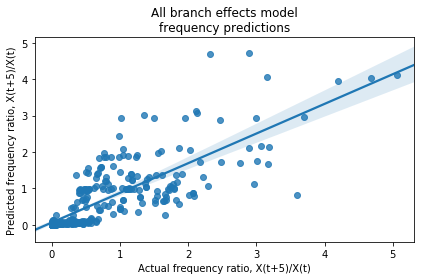

In [12]:
compare_predictions(actual_frequency_ratio, clade_predicted_frequency_ratio, loglog=False, title='All branch effects model\nfrequency predictions')

LinregressResult(slope=0.81684308557805163, intercept=0.060639210286609457, rvalue=0.8029489817595723, pvalue=2.4922981253422887e-81, stderr=0.032273375668818917)


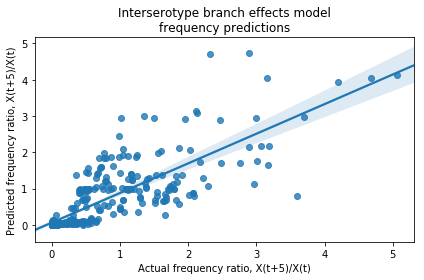

In [13]:
compare_predictions(actual_frequency_ratio, intersero_predicted_frequency_ratio, loglog=False, title='Interserotype branch effects model\nfrequency predictions')

LinregressResult(slope=1.7305710940725232, intercept=0.46386854820160994, rvalue=0.59049582231103759, pvalue=1.7407847866456621e-11, stderr=0.22972862757620402)


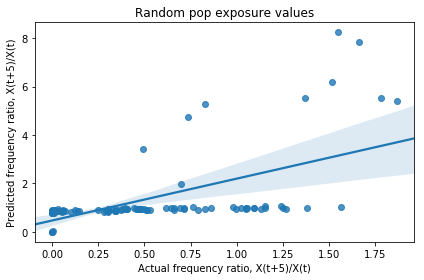

In [14]:
compare_predictions(actual_frequency_ratio, jitter_test_predicted_frequency_ratio, loglog=False, 
                    title='Random pop exposure values')

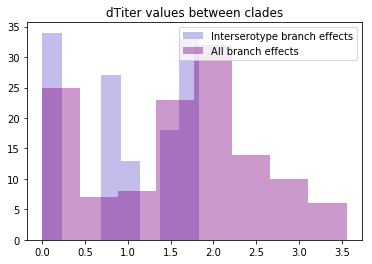

In [15]:
sns.distplot(pd.Series(interserotype_effects_dTiters.values()), 
             label='Interserotype branch effects', color='slateblue', bins=8, kde=False)
sns.distplot(pd.Series(all_branch_effects_dTiters.values()),
             label='All branch effects', color='purple', bins=8, kde=False)
plt.legend()
plt.title('dTiter values between clades')
plt.show()

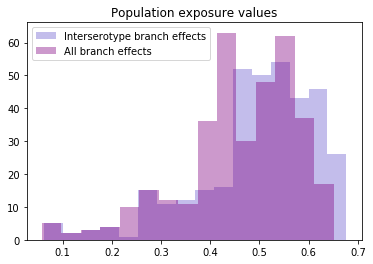

In [19]:
sns.distplot(pd.Series(sero_exposure.values.flatten()[~ np.isnan(sero_exposure.values.flatten())]), 
              label='Interserotype branch effects', color='slateblue', kde=False)
sns.distplot(pd.Series(clade_exposure.values.flatten()[~ np.isnan(clade_exposure.values.flatten())]), 
              label='All branch effects', color='purple', kde=False)
plt.legend()
plt.title('Population exposure values')
plt.show()

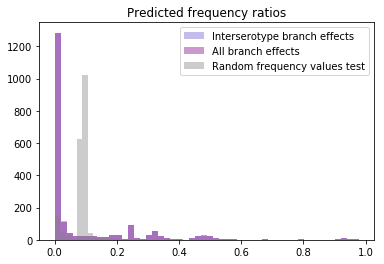

mean values for predicted frequency ratios:
interserotype:  0.0909090909091
all branch effects:  0.0909090909091
random values:  0.0909090909091


In [20]:
sns.distplot(pd.Series(intersero_predicted_frequencies.values.flatten()[~ np.isnan(intersero_predicted_frequencies.values.flatten())]), 
              label='Interserotype branch effects', color='slateblue', kde=False)
sns.distplot(pd.Series(clade_predicted_frequencies.values.flatten()[~ np.isnan(clade_predicted_frequencies.values.flatten())]), 
              label='All branch effects', color='purple', kde=False)
sns.distplot(pd.Series(jitter_test_predicted_frequencies.values.flatten())[~np.isnan(jitter_test_predicted_frequencies.values.flatten())], 
            label='Random frequency values test', color='gray', kde=False)
plt.legend()
plt.title('Predicted frequency ratios')
plt.show()

print 'mean values for predicted frequency ratios:'
print 'interserotype: ', intersero_predicted_frequencies.mean().mean()
print 'all branch effects: ', clade_predicted_frequencies.mean().mean()
print 'random values: ', jitter_test_predicted_frequencies.mean().mean()

In [21]:
demo_pop_exposure = pd.DataFrame([[0.3,0.6],
                                 [0.4,0.5],
                                 [0.5,0.4]], 
                                 index=[1980., 1981., 1982.], 
                                 columns=['clade A', 'clade B'])

demo_frequencies = pd.DataFrame([[0.5,0.5],
                                [0.6,0.4],
                                [0.7,0.3]], 
                               index=[1980., 1981., 1982.],
                               columns=['clade A', 'clade B'])

print 'demo population exposure (Pi) values'
print predict_frequencies(demo_pop_exposure, demo_frequencies, 1)

print '\n\ndemo predicted frequency values'
demo_pop_exposure = demo_pop_exposure.applymap(lambda x: x + random())
demo_freq_pred = predict_frequencies(demo_pop_exposure, demo_frequencies, 1)
print demo_freq_pred

print '\n\ndemo predicted frequency ratio values'
demo_freq_ratio = get_frequency_ratio(pivots=[1980., 1981., 1982.], pivots_forward=1, informative_date_range=(1980., 1982.),
                                 frequencies=demo_freq_pred)
print demo_freq_ratio

demo population exposure (Pi) values
         clade A   clade B
1980.0  0.551994  0.448006
1981.0  0.570526  0.429474
1982.0  0.589434  0.410566


demo predicted frequency values
         clade A   clade B
1980.0  0.474241  0.525759
1981.0  0.490741  0.509259
1982.0  0.336710  0.663290


demo predicted frequency ratio values
         clade A   clade B
1980.0  1.034792  0.968617
1981.0  0.686126  1.302461


In [22]:
# def test_year_params(years_forward, years_back, clades, antigenic_resolution):
#     ##### TIMEPOINTS PARSING #####
#     #  pivots = augur jargon for time points; used here for consistency across codebase

#     pivots_back = years_back*ppy
#     pivots_forward = years_forward*ppy

#     # pivots with enough data before to infer population exposure AND enough data after to test prediction
#     informative_pivots = pivots[pivots_back:-1*pivots_forward] 
#     informative_date_range = (informative_pivots[0], informative_pivots[-1])

#     if years_forward in precalculated_frequency_ratios:
#         frequency_ratio = precalculated_frequency_ratios[years_forward]
#     else:
#         frequency_ratio = get_frequency_ratio(pivots, pivots_forward, informative_date_range, frequencies)
#         precalculated_frequency_ratios[years_forward] = frequency_ratio
        
#     population_exposure = calc_all_population_exposure(gamma=-0.125, sigma=-0.15, 
#                                                  all_clades=clades, 
#                                                  antigenic_resolution=antigenic_resolution, 
#                                                  frequencies=frequencies, frequency_ratio=frequency_ratio,
#                                                  pivots=pivots, ppy=ppy, 
#                                                  pivots_back=pivots_back,
#                                                  informative_pivots=informative_pivots, 
#                                                  max_years_back=years_back,
#                                                  informative_date_range=informative_date_range)
    
#     pooled = pool_analysis(population_exposure, 
#                                                antigenic_resolution=antigenic_resolution, 
#                                                years_forward=years_forward)
    
#     pooled_fit = stats.linregress(pooled['pooled_exposure'], pooled['pooled_frequency_ratio'])
#     return pooled_fit.rvalue

# resolutions = ['clade', 'serotype']
# clades = [genotype_clades, serotype_clades]

# clade_frequency_predictions = []

# time_frames = [1,3,5,8,10]

# for res in resolutions:
#     for cl in clades:
#         for yrs_fwd in time_frames:
#             for yrs_back in time_frames:
#                 log = {'antigenic_resolution': res, 
#                       'genetic_resolution': len(cl),
#                       'years_forward': yrs_fwd,
#                       'years_back': yrs_back,
#                       'rvalue': test_year_params(yrs_fwd, yrs_back, cl, res)}
#                 clade_frequency_predictions.append(log)